In [3]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import os
from tqdm import tqdm
import GPUtil as GPU
from torch.utils.data import DataLoader, Dataset
import cv2
from torchvision.transforms import *


In [4]:
train_mask=pd.read_csv('train_masks.csv')
metadata=pd.read_csv('metadata.csv')
submission=pd.read_csv('sample_submission.csv')

In [5]:
train_images= os.listdir('train_hq')
test_images= os.listdir('test_hq')
train_masks= os.listdir('train_masks')
train_path= [os.path.join('train',i) for i in os.listdir('train')]
test_path=[os.path.join('test',i) for i in os.listdir('test')]
mask_path=[os.path.join('train_masks',i) for i in os.listdir('train_masks')]

In [6]:
print(len(test_images)/16)

6254.0


There are 318 training images, and 6254 test images. No of training images>test images so that might create a problem. Valdimir approaches this by pseudo labelling, see what it is later on.

In [7]:
from PIL import Image
def plot_image_and_mask(train_images):
    #plot the train_images
    figure,axis=plt.subplots(len(train_images),2,figsize=(2*10,10*len(train_images)))
    for i in range(len(train_images)):
        id=train_images[i]
        image_path=os.path.join('train',id)
        mask_path=os.path.join('train_masks',id)[:-4]+'_mask.gif'
        print(np.array(Image.open(image_path)).shape)
        axis[i][0].imshow(Image.open(image_path))
        axis[i][1].imshow(Image.open(mask_path))

(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)


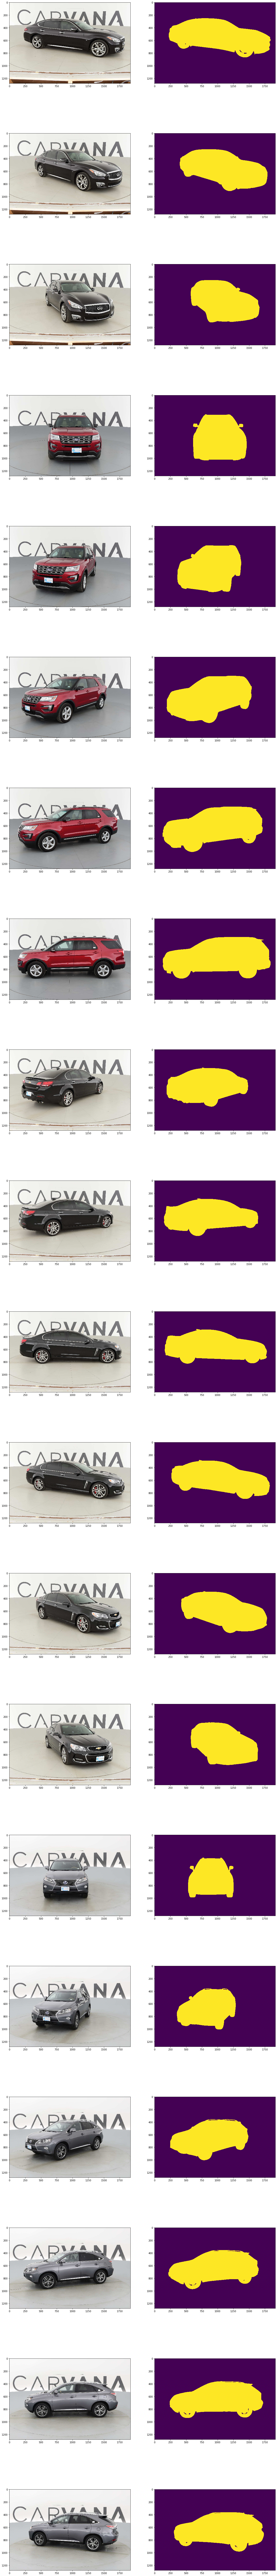

In [8]:
plot_image_and_mask(train_images[50:70])

shutil craetes symbolic link to the directories where the files are copied. When we create folds, the data does not disappear.

In [ ]:
'''run when need to create folds on the local machine'''
# #test code to create the folds 
# from pathlib import Path
# import shutil
# local_data_path=Path('.').absolute()/'folds'
# local_data_path.mkdir(exist_ok=True)
# train_path= Path('.').absolute()/'train_hq/'
# mask_path=Path('.').absolute()/'train_masks'
# train_file_list=train_images
# folds=pd.read_csv('folds_csv.csv')
# num_folds=folds.fold.nunique()
# #the cars are at sixteen angles 
# angles=['0'+ str(i) for i in range (1,10)]+ [str(i) for i in range(10,17)]
# #now create the folder containing the folds 
# for fold in range(num_folds):
#     #create the folder correspoonding to number of folds
#     (local_data_path / str(fold) / 'train' / 'images').mkdir(exist_ok=True, parents=True)
#     (local_data_path / str(fold) / 'train' / 'masks').mkdir(exist_ok=True, parents=True)

#     (local_data_path / str(fold) / 'val' / 'images').mkdir(exist_ok=True, parents=True)
#     (local_data_path / str(fold) / 'val' / 'masks').mkdir(exist_ok=True, parents=True)

# for i in tqdm(folds.index):
#     car_id=folds.loc[i,'id']
#     fold=folds.loc[i,'fold']
#     #copy the 16 images to fold directory 
#     #this is considered as a val this time 
#     for angle in angles:
#         old_image_path = train_path / (car_id + '_' + angle + '.jpg')

#         new_image_path = local_data_path / str(fold) / 'val' / 'images' / (car_id + '_' + angle + '.jpg')
#         shutil.copy(str(old_image_path), str(new_image_path))

#         old_mask_path = mask_path / (car_id + '_' + angle + '_mask.gif')
#         new_mask_path = local_data_path / str(fold) / 'val' / 'masks' / (car_id + '_' + angle + '_mask.gif')
#         shutil.copy(str(old_mask_path), str(new_mask_path))
        
#     #for all the other folds this will be considered as a  training image
#     for t_fold in range(num_folds):
#             if t_fold == fold:
#                 continue

#             for angle in angles:
#                 old_image_path = train_path / (car_id + '_' + angle + '.jpg')

#                 new_image_path = local_data_path / str(t_fold) / 'train' / 'images' / (car_id + '_' + angle + '.jpg')
#                 shutil.copy(str(old_image_path), str(new_image_path))

#                 old_mask_path = mask_path / (car_id + '_' + angle + '_mask.gif')
#                 new_mask_path = local_data_path / str(t_fold) / 'train' / 'masks' / (car_id + '_' + angle + '_mask.gif')
#                 shutil.copy(str(old_mask_path), str(new_mask_path))

100%|██████████| 318/318 [07:42<00:00,  1.36s/it]


We take care of the modelling now. The original implementation used unet 11 with a pre-trained vgg-11 encoder, which is what we will use.

In [13]:
#modelling
from torch import nn 
from torch.nn import functional as F
import torch 
from torchvision import models

Vladimir uses the Unet architecture for semantic segmentation. The modifications to the net are taurusunet where a pre-trained encoder is used for the segmentation. Let's try to do the modelling here and try to understand the input dimensions.

In [14]:
#handle multiple gpus in the jupyter notebook 
device=torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

if device.type=='cuda':
    gpu_id=[]
    GPUs = GPU.getGPUs()
    for i in range(len(GPUs)):
        gpu = GPUs[i]
        if gpu.memoryFree>5000:
            gpu_id.append(i)

In [10]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


def concat(xs):
    return torch.cat(xs, 1)


class Conv3BN(nn.Module):
    def __init__(self, in_: int, out: int, bn=False):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.bn = nn.BatchNorm2d(out) if bn else None
        self.activation = nn.SELU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        x = self.activation(x)
        return x

    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)
    

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


In [16]:

class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.encoder = models.vgg11(pretrained=True).features
        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return F.sigmoid(self.final(dec1))

    
#writing the dice based loss weights for the neural network 

class Loss:
    #init script for the loss
    def __init__(self, dice_weight=1):
        self.nll_loss = nn.BCELoss()
        self.dice_weight = dice_weight

    #call called if parameters are given to the network 
    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)
        if self.dice_weight:
            eps = 1e-15
            dice_target = (targets == 1).float()
            dice_output = outputs
            intersection = (dice_output * dice_target).sum()
            union = dice_output.sum() + dice_target.sum() + eps

            loss -= torch.log(2 * intersection / union)

        return loss


In [21]:
#create a dataloader for the carvana dataset
train_images= os.listdir('train_hq')
test_images= os.listdir('test_hq')
train_masks= os.listdir('train_masks')
train_path= [os.path.join('train',i) for i in os.listdir('train')]
test_path=[os.path.join('test',i) for i in os.listdir('test')]
mask_path=[os.path.join('train_masks',i) for i in os.listdir('train_masks')]

'''returns the padded image'''
#writing the image loader function 
def load_image(path):
    img=cv2.imread(path)
    img = cv2.copyMakeBorder(img, 0, 0, 1, 1, cv2.BORDER_REFLECT_101)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.uint8)
'''returns the mask'''
def load_mask(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            if '.gif' in str(path):
                img = (np.asarray(img) > 0)
            else:
                img = (np.asarray(img) > 255 * 0.5)
            img = cv2.copyMakeBorder(img.astype(np.uint8), 0, 0, 1, 1, cv2.BORDER_REFLECT_101)
            return img.astype(np.float32)
        

        
        
'''since we are feeding the images to pretrained vgg11, we need to normalize the weights
https://pytorch.org/docs/stable/torchvision/models.html
make a transformation pipeline for input images in the carvana dataset'''

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#our dataloader should also handle the image augmentation 
#inherit the Dataset
class CarvanaDataset(Dataset):
    def __init__(self,train_path,mask_path):
        self.image_path= train_path
        self.mask_path= mask_path
        
    #return the length of teh dataset
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self,idx):
        img=load_image(self.image_path[idx])
        mask= load_mask(self.mask_path[idx])
        
        return img_transform(img), torch.from_numpy(np.expand_dims(mask,0))
     
    
    